## Generating training set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import mlflow

Using TensorFlow backend.


In [3]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path
import os
import logging
from copy import copy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

# logging.basicConfig(level=logging.DEBUG)

In [4]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')

CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

mlflow.set_tracking_uri(str(Path(path_to_data, 'mlruns')))

In [6]:
import glob
import yaml

path_to_mlflow = '/home/Edu/data/mlruns'
meta = glob.glob(str(Path(path_to_mlflow, '**/meta.yaml')))

def load_yaml(path):
    with open(path) as f:
        content = yaml.load(f)
    return content

experiments = [load_yaml(p) for p in meta]

def get_id_for_experiment_with_name(name):
    matches = [e['experiment_id'] for e in experiments if e['name'] == name]

    if len(matches):
        return matches[0]
    else:
        return mlflow.create_experiment(name)

experiment_name = 'denoiser-training-set'
EXPERIMENT_ID = get_id_for_experiment_with_name(experiment_name)

In [7]:
print('Running YASS version: {}\nExperiment: {} (id: {})'
      .format(yass_util.get_version(), experiment_name, EXPERIMENT_ID))

Running YASS version: 01bd23e min shift param is now passed through collided params
Experiment: denoiser-training-set (id: 1)


In [8]:
templates = np.load('/home/Edu/data/cat/templates-jul27-only-good.npy')

In [9]:
from yass.batch import RecordingsReader

rec = RecordingsReader(path_to_standarized, loader='array').data

In [10]:
(spatial_sig,
 temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

In [11]:
min_amplitude = 5
max_amplitude = 10
n_clean_per_template = 60

parameters = dict(units_per_bin=10,
                  include_clean_data=True,
                  templates=templates,
                  min_amplitude=min_amplitude,
                  max_amplitude=min_amplitude,
                  n_per_template=n_clean_per_template,
                  spatial_sig=spatial_sig,
                  temporal_sig=temporal_sig,
                  make_from_templates=True,
                  make_spatially_misaligned=False,
                  make_temporally_misaligned=False,
                  make_collided=False,
                  make_noise=False,
                  return_metadata=False,
                  temporally_misaligned_kwargs=dict(n_per_spike=10),
                  collided_kwargs=dict(n_per_spike=5, min_shift=5),
                  spatially_misaligned_kwargs=dict(n_per_spike=5))

dataset = evaluate.Dataset.make(**parameters)

In [12]:
dataset.stats

{'from templates': 14400}

In [13]:
dataset.data_clean.shape

(14400, 61, 49)

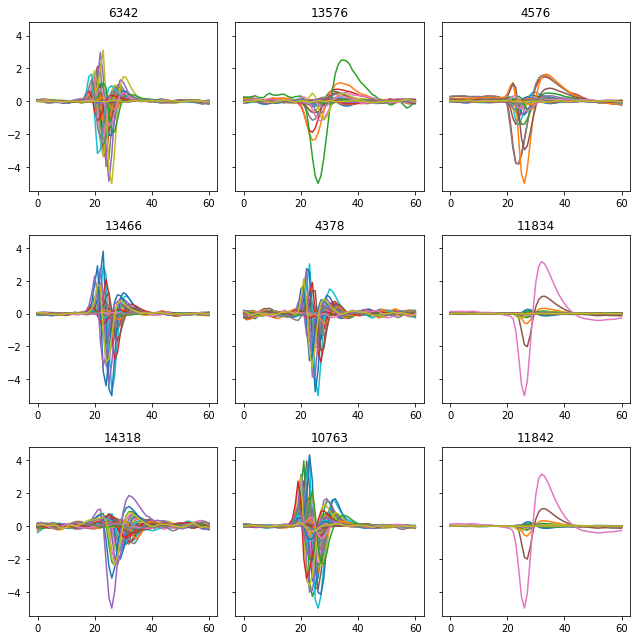

In [14]:
if parameters['make_from_templates']:
    plot.grid_from_array(dataset.get_kind('from templates').data_clean,
                     axis=0, elements=9,
                     auto_figsize=3, sharey=True)

In [15]:
if parameters['make_temporally_misaligned']:
    plot.grid_from_array(dataset.get_kind('spatially misaligned').data_clean,
                         axis=0, elements=range(9),
                         auto_figsize=3, sharey=True)

In [16]:
if parameters['make_temporally_misaligned']:
    plot.grid_from_array(dataset.get_kind('temporally misaligned').data_clean,
                         axis=0, elements=range(9),
                         auto_figsize=3, sharey=True)

In [17]:
if parameters['make_collided']:
    plot.grid_from_array(dataset.get_kind('collided').data_clean,
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

In [18]:
if parameters['make_noise']:
    plot.grid_from_array(dataset.get_kind('noise').data_clean,
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

## Generating train and test sets

In [19]:
data_noisy = dataset.data
data_clean = dataset.data_clean

(x_train_noisy,
 x_train_clean,
 x_test_noisy,
 x_test_clean) = evaluate.split(data_noisy, data_clean,
                                train_proportion=0.7)

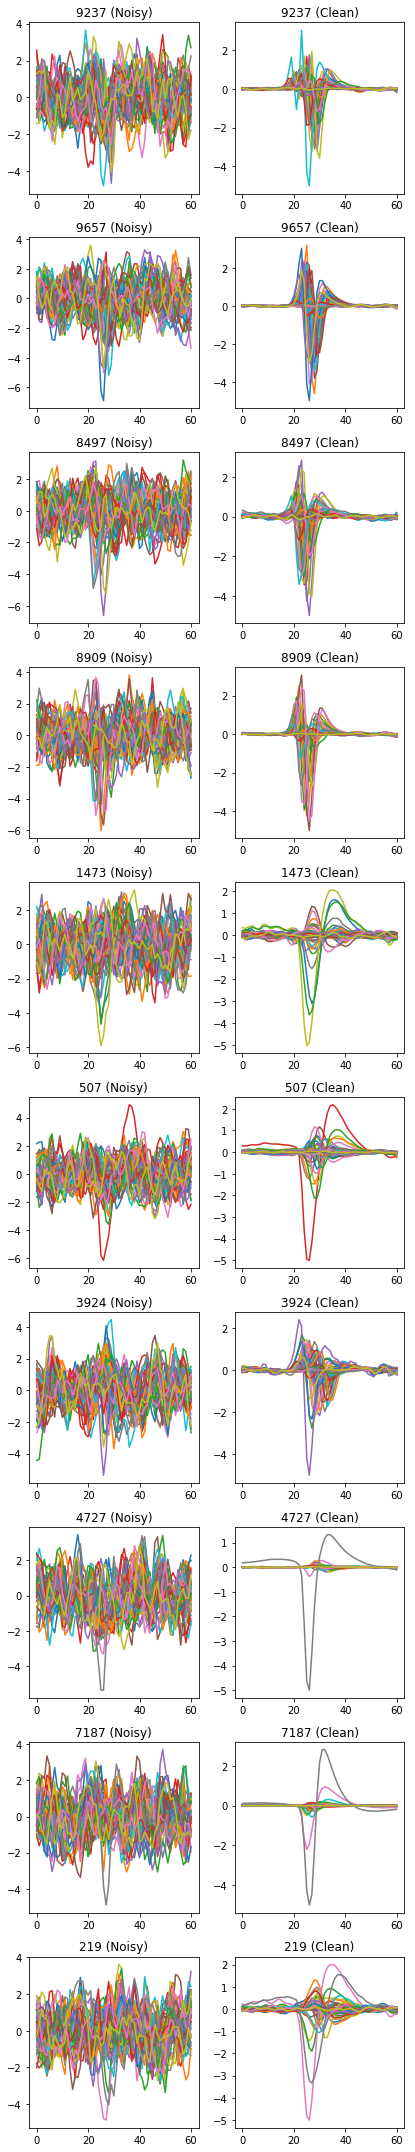

In [20]:
plot.grid_from_array([x_train_noisy, x_train_clean],
                     axis=0,
                     elements=10,
                     group_names=('Noisy', 'Clean'),
                     auto_figsize=3)

In [22]:
NAME = 'only from templates'

In [23]:
sum(dataset.stats.values())

14400

In [24]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=NAME):
    parameters_to_save = copy(parameters)
    
    parameters_to_save.pop('templates')
    parameters_to_save.pop('temporal_sig')
    parameters_to_save.pop('spatial_sig')
    
    path_to_set = Path(path_to_data, 'denoiser', 'dataset.npz')
    np.savez(path_to_set, x_train_noisy=x_train_noisy, x_train_clean=x_train_clean,
             x_test_noisy=x_test_noisy, x_test_clean=x_test_clean,
             temporal_sig=temporal_sig, spatial_sig=spatial_sig)
    
    for name, value in parameters_to_save.items():
        mlflow.log_param(name, value)
    
    mlflow.log_param('size', sum(dataset.stats.values()))
#     mlflow.log_param('name', name)

    mlflow.log_artifact(str(path_to_set))
    
    os.remove(Path(path_to_set))
    
    print(mlflow.active_run().info.run_uuid)

4bc82282d1254434ba0d8226a87d0b87
